# Annotating certificate references with LLMs
## Before you launch
1. Create a file `openai_api_key` in the root directory and paste your key there.
2. Make sure you have the CC dataset extracted into project `cc_data` in the project root directory.
## What is being done here
1. Obtain names, certificate IDs, digests, and old digests from the CCDataset.
2. Create an annotations dataframe based on the annotations in `src/sec_certs/data/reference_annotations/final/train.csv`.
3. Enrich the annotations dataframe with the raw texts in `cc_data/certs/reports/txt`.
4. Enrich the annotations dataframe with the old digests (the annotation dataframe uses old ones), target cert IDs, names and target names.
5. Call the OpenAI API with structured outputs to label the certificate reference based on instructions in `notebooks/llm_annotation_prompt.txt`
6. Analyze the metrics with a confusion matrix.

In [2]:
from sec_certs.dataset.cc import CCDataset
from sec_certs.sample import CCCertificate
import pandas as pd
import csv
import os

In [3]:
if "dgst_map.csv" not in os.listdir():
    # get dgst mappings
    dset = CCDataset.from_web()
    data = [(row.name, row.heuristics.cert_id, row.dgst, row.old_dgst) for row in dset]
    with open('dgst_map.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['name', 'cert_id', 'dgst', 'old_dgst'])  # Header
        writer.writerows(data)
dgst_map_df = pd.read_csv("dgst_map.csv")

In [4]:
reports_path = '../../cc_data/certs/reports/txt'
if not os.path.exists(reports_path):
    raise FileNotFoundError(f"The reports directory {os.path.abspath(reports_path)} does not exist, make sure you have the CC dataset unpacked.")

reports_files = os.listdir(reports_path)
# print(reports_files)
def add_text_content(dgst: str):
    if f"{dgst}.txt" not in reports_files:
        return ""
    return open(reports_path + "/" + dgst + ".txt").read()

In [5]:
df_annotations = pd.read_csv("../../src/sec_certs/data/reference_annotations/final/train.csv") \
    .rename(columns={"dgst": "old_dgst", "canonical_reference_keyword": "target_cert_id"}) \
    .merge(dgst_map_df, on="old_dgst") \
    .merge(dgst_map_df[["name", "cert_id"]].rename(columns={"name": "target_name", "cert_id": "target_cert_id"}), on="target_cert_id")
df_annotations["text_content"] = df_annotations["dgst"] \
    .apply(add_text_content)

In [6]:
df_annotations.head()

,old_dgst,target_cert_id,label,comment,name,cert_id,dgst,older_dgst,target_name,text_content
0,00efeb17bcaafce6,ANSSI-CC-2009/34,component_used,NaN,Trusted Logic. Carte à puce JCLXxxjTOPyyIDv2 :...,ANSSI-CC-2009/35,4e9ff22a844c6003,6f55526f9162a4bb,JCLX80jTOP20ID : Java Trusted Open Platform IF...,PREMIER MINISTRE\nSecrétariat général de la dé...
1,01e8805514b4ef67,BSI-DSZ-CC-0891-V3-2018,component_used,NaN,ID&Trust IDentity-J with SAC (BAC+PACE) and AA...,JISEC-CC-CRP-C0649-01-2019,abb304884762a560,42586e3d73fb8bd4,Infineon Security Controller M7892 Design Step...,JISEC-CC-CRP-C0649-01-2019\nCertification Repo...
2,037577fc2019fcfa,ANSSI-CC-2021/49,previous_version,NaN,NPCT7xx TPM2.0 rev 1.59 (configuration version...,ANSSI-CC-2022/28,88b3519651a7b7c0,cca6ba2fdb06af5a,NPCT7xx TPM2.0 rev 1.59 (configuration version...,Secrétariat général de la défense\net de la sé...
3,055985699aee1e09,ANSSI-CC-2010/02,component_used,NaN,Carte CC IDeal Citiz (sur composants SB23YR80B...,ANSSI-CC-2011/62,338e26cd240f6572,700f9a9a01a58722,STMicroelectronics SA23YR48/80B and SB23YR48/8...,PREMIER MINISTRE\nSecrétariat général de la dé...
4,05726637bd47a762,BSI-DSZ-CC-0891-V3-2018,component_used,NaN,Java Card Platform Implementation for Infineon...,BSI-DSZ-CC-0869-V2-2019,179ef93627203d9f,377db3692d1a6bf6,Infineon Security Controller M7892 Design Step...,BSI-DSZ-CC-0869-V2-2019\nfor\nJava Card Platfo...


In [7]:
from enum import Enum
from pydantic import Field, BaseModel
from openai import AsyncOpenAI, RateLimitError
import asyncio
from openai.lib._pydantic import to_strict_json_schema

class LabelType(Enum):
    COMPONENT_USED = "component_used"
    RE_EVALUATION = "re-evaluation"
    EVALUATION_REUSED = "evaluation_reused"
    PREVIOUS_VERSION = "previous_version"
    COMPONENT_SHARED = "component_shared"
    IRRELEVANT = "irrelevant"
    NONE = "none"

class SimplifiedLabelType(Enum):
    COMPONENT_REUSE = "component_reuse"
    PREDECESSOR = "predecessor" 
    NONE = "none"

def convert_label_type(label: LabelType|str) -> SimplifiedLabelType:
    if isinstance(label, LabelType):
        label_value = label
    else:
        try:
            label_value = LabelType(label)
        except ValueError:
            return SimplifiedLabelType.NONE
    
    if label_value in [LabelType.COMPONENT_USED, LabelType.EVALUATION_REUSED, LabelType.COMPONENT_SHARED]:
        return SimplifiedLabelType.COMPONENT_REUSE
    elif label_value in [LabelType.RE_EVALUATION, LabelType.PREVIOUS_VERSION]:
        return SimplifiedLabelType.PREDECESSOR
    return SimplifiedLabelType.NONE

class LabelDetectionResult(BaseModel):
    explanation: str = Field(description="Explain why this label was chosen.")
    label: LabelType = Field(description="Categorization of the relationship between the examined and referenced certificates.")

#label_detection_strict_schema = to_strict_json_schema(LabelDetectionResult)

In [8]:
df_annotations.label.value_counts()

label
component_used       58
re-evaluation        16
evaluation_reused    11
previous_version      6
component_shared      5
irrelevant            2
Name: count, dtype: int64

In [9]:
df_annotations.label.apply(convert_label_type).apply(lambda x: x.value).value_counts()

label
component_reuse    74
predecessor        22
none                3
Name: count, dtype: int64

In [10]:
def load_api_key(filename: str) -> str:
    try:
        with open(filename, 'r') as file:
            api_key = file.readline().strip()
            return api_key
    except FileNotFoundError:
        raise Exception(f"OpenAI API key not found at {filename}.")

api_key = load_api_key('../../openai_api_key')
openapi_model = "gpt-4o-mini"
print(f"API Key loaded: {api_key[:12]}...")
client = AsyncOpenAI(api_key=api_key)

API Key loaded: sk-proj-tco-...


In [69]:
system_message = {
    "role": "system",
    "content": open("llm_annotation_prompt.txt").read()
}
async def get_ai_label(text_content: str, name: str, target_name: str, cert_id: str, target_cert_id: str, verbose=False):
    messages = [
        system_message,
        {"role": "user", "content": f"""
        Task: Classify how certificate {cert_id} refers to certificate {target_cert_id}. Note that you are to classify ONLY this relationship, and not relationships to other mentioned certificates or their components. Refer to the instructions and examples in the system message.

        Target: {target_cert_id} ({target_name})
        Reviewed: {cert_id} ({name})

        Text from reviewed certificate {cert_id}:
        '{text_content}'
        """}
    ]
    while True:
        try:
            completion = await client.beta.chat.completions.parse(
                model=openapi_model,
                messages=messages,
                response_format=LabelDetectionResult
            )
            return completion.choices[0].message.parsed
        except Exception as e:
            wait_time = 60
            if verbose:
                print(f"Error: {e}, retrying in {wait_time}s..")
            await asyncio.sleep(wait_time)

In [70]:
from tqdm.asyncio import tqdm

In [71]:
async def process_row_async(text_content: str, name: str, target_name: str, cert_id: str, target_cert_id: str):
    result = await get_ai_label(text_content, name, target_name, cert_id, target_cert_id)
    return result.label.value, result.explanation
async def process_dataframe_async(df):
    tasks = [process_row_async(
        row["text_content"], 
        row["name"], 
        row["target_name"],
        row["cert_id"],
        row["target_cert_id"]) for _, row in df.iterrows()]
    results = []
    for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks)):  # tracks actual completion
        results.append(await coro)
    return results
import nest_asyncio # otherwise async tasks can't be called from a running event loop (jupyter)
nest_asyncio.apply()

In [72]:
# running this cell costs about 0.15EUR with gpt4o-mini
if "llm_annotation_results.parquet" not in os.listdir(): # delete the file if you want to re-run things
    results = asyncio.run(process_dataframe_async(df_annotations))
    df_annotations["gpt4omini_label"], df_annotations["gpt4omini_reason"] = zip(*results)
    df_annotations.to_parquet("llm_annotation_results.parquet")
df_results = pd.read_parquet("llm_annotation_results.parquet")

100%|██████████| 99/99 [06:56<00:00,  4.21s/it]


In [73]:
df_results[["target_cert_id", "cert_id", "name", "target_name", "label", "comment", "gpt4omini_label", "gpt4omini_reason"]]

,target_cert_id,cert_id,name,target_name,label,comment,gpt4omini_label,gpt4omini_reason
0,ANSSI-CC-2009/34,ANSSI-CC-2009/35,Trusted Logic. Carte à puce JCLXxxjTOPyyIDv2 :...,JCLX80jTOP20ID : Java Trusted Open Platform IF...,component_used,None,previous_version,The ANSSI-CC-2016/69 certificate is a newer ve...
1,BSI-DSZ-CC-0891-V3-2018,JISEC-CC-CRP-C0649-01-2019,ID&Trust IDentity-J with SAC (BAC+PACE) and AA...,Infineon Security Controller M7892 Design Step...,component_used,None,component_used,The examined certificate NSCIB-CC-146301-CR2 r...
2,ANSSI-CC-2021/49,ANSSI-CC-2022/28,NPCT7xx TPM2.0 rev 1.59 (configuration version...,NPCT7xx TPM2.0 rev 1.59 (configuration version...,previous_version,None,component_used,The ANSSI-CC-2018/44-S01 certificate explicitl...
3,ANSSI-CC-2010/02,ANSSI-CC-2011/62,Carte CC IDeal Citiz (sur composants SB23YR80B...,STMicroelectronics SA23YR48/80B and SB23YR48/8...,component_used,None,evaluation_reused,The certificate ANSSI-CC-2022/28 explicitly st...
4,BSI-DSZ-CC-0891-V3-2018,BSI-DSZ-CC-0869-V2-2019,Java Card Platform Implementation for Infineon...,Infineon Security Controller M7892 Design Step...,component_used,None,evaluation_reused,The evaluated certificate ANSSI-CC-2022/29 sta...
...,...,...,...,...,...,...,...,...
94,ANSSI-CC-2012/68,ANSSI-CC-2014/25,"SOMA801STM - application BAC, version 1.0",Microcontrôleurs sécurisés SA23YR80/48 et SB23...,component_used,None,re-evaluation,The text from the reviewed certificate BSI-DSZ...
95,ANSSI-CC-2017/47,ANSSI-CC-2017/72,"Taiwan eID Applet PACE with CAM, CA and AA on ...",Plateforme ID-One Cosmo v8.1-N-Standard LDS ma...,component_used,None,evaluation_reused,The referenced certificate BSI-DSZ-CC-0957-V2-...
96,BSI-DSZ-CC-0945-V2-2018,NSCIB-CC-200689-CR,Idemia CombICAO Applet in EAC configuration on...,Infineon smart card IC (Security Controller) I...,irrelevant,None,re-evaluation,The reviewed certificate BSI-DSZ-CC-0976-V2-20...
97,BSI-DSZ-CC-0950-V2-2018,BSI-DSZ-CC-0596-V2-2018,ORGA 930 M online and Cherry ST-1530,"KoCoBox MED+ Netzkonnektor, 1.3.4",None,"unclear, mentions just ToE delivery",previous_version,BSI-DSZ-CC-0911-2014 provides Basic Access Con...


In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [75]:
df_results = df_results[(~df_results["label"].isin(["none", "irrelevant", None]) & (~df_results["gpt4omini_label"].isin(["none", "irrelevant"])))]

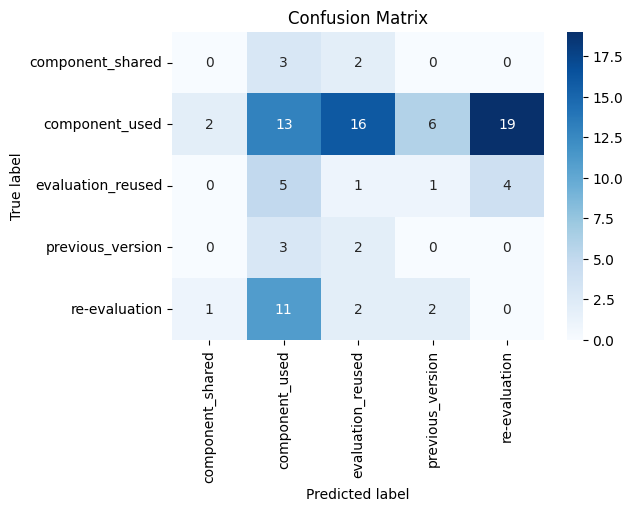

Accuracy: 0.1505, F1 score: 0.1790


In [ ]:
conf_matrix = pd.crosstab(df_results["label"], df_results["gpt4omini_label"])
accuracy = (df_results["label"] == df_results["gpt4omini_label"]).mean()
f1 = f1_score(df_results["label"], df_results["gpt4omini_label"], average='weighted')
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(f"Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}")

In [77]:
df_results["label_simple"] = df_results["label"].apply(convert_label_type).apply(lambda x: x.value)
df_results["gpt4omini_label_simple"] = df_results["gpt4omini_label"].apply(convert_label_type).apply(lambda x: x.value)

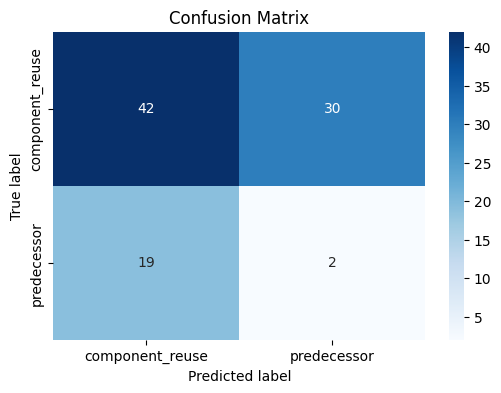

Accuracy: 0.4731, F1 score: 0.5060


In [86]:
conf_matrix = pd.crosstab(df_results["label_simple"], df_results["gpt4omini_label_simple"])
accuracy = (df_results["label_simple"] == df_results["gpt4omini_label_simple"]).mean()
f1 = f1_score(df_results["label_simple"], df_results["gpt4omini_label_simple"], average='weighted')

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(f"Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}")